In [170]:
# Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [171]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=200

In [172]:
#import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "disease_folder",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 900 files belonging to 11 classes.


In [173]:

class_names = dataset.class_names
class_names

['Aphids',
 'Eggplant mottled dwarf virus',
 'Fusarium Wilt',
 'Healthy Fruits',
 'Healthy plant',
 'Phomopsis fruit rot',
 'Ralstonia wilt',
 'Verticillium Wilt',
 'jassids',
 'root-knot nematodes',
 'shoot and fruit borer']

In [174]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 4 10 10  9  4  5  8  5  3  4  1  4  7  5 10  9  4  2  5  5  8 10  4  4
 10  4  3  2  7  8  1 10]


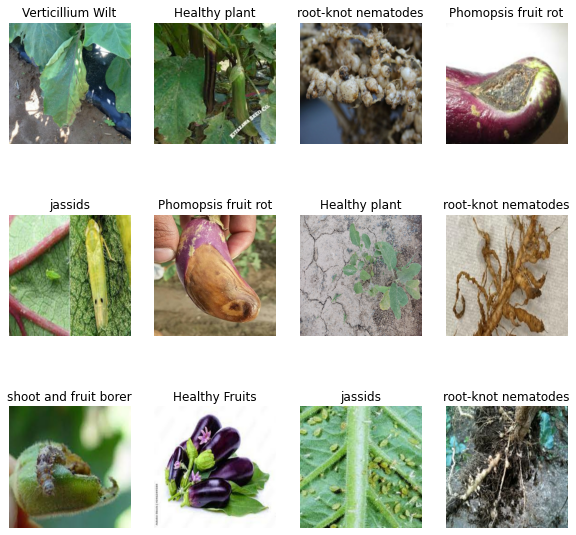

In [175]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [176]:
#Function to Split Dataset
len(dataset)

29

In [177]:
train_size = 0.8
len(dataset)*train_size

23.200000000000003

In [178]:
train_ds = dataset.take(54)
len(train_ds)

29

In [179]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [180]:
val_size=0.1
len(dataset)*val_size

2.9000000000000004

In [181]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [182]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [183]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [184]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [185]:
len(train_ds)

23

In [186]:
len(val_ds)

2

In [187]:
len(test_ds)

4

In [188]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [189]:
#Building the Model
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [190]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [191]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [192]:
#Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [193]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (32, 60, 60, 64)        

In [194]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [195]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=200,
)

Epoch 1/200
23/23 [==============================] - 92s 3s/step - loss: 2.2835 - accuracy: 0.2232 - val_loss: 2.1240 - val_accuracy: 0.2500
Epoch 2/200
23/23 [==============================] - 43s 2s/step - loss: 2.2155 - accuracy: 0.2627 - val_loss: 2.2622 - val_accuracy: 0.2500
Epoch 3/200
23/23 [==============================] - 44s 2s/step - loss: 2.1823 - accuracy: 0.2627 - val_loss: 2.1104 - val_accuracy: 0.2500
Epoch 4/200
23/23 [==============================] - 44s 2s/step - loss: 2.1336 - accuracy: 0.2627 - val_loss: 2.1101 - val_accuracy: 0.2500
Epoch 5/200
23/23 [==============================] - 43s 2s/step - loss: 2.0873 - accuracy: 0.2740 - val_loss: 2.0189 - val_accuracy: 0.2969
Epoch 6/200
23/23 [==============================] - 43s 2s/step - loss: 2.0337 - accuracy: 0.2938 - val_loss: 1.9744 - val_accuracy: 0.2969
Epoch 7/200
23/23 [==============================] - 44s 2s/step - loss: 1.9543 - accuracy: 0.3234 - val_loss: 1.9019 - val_accuracy: 0.3125
Epoch 8/200
2

Epoch 59/200
23/23 [==============================] - 43s 2s/step - loss: 1.0269 - accuracy: 0.6314 - val_loss: 1.1761 - val_accuracy: 0.6094
Epoch 60/200
23/23 [==============================] - 43s 2s/step - loss: 0.9393 - accuracy: 0.6540 - val_loss: 1.0965 - val_accuracy: 0.5469
Epoch 61/200
23/23 [==============================] - 43s 2s/step - loss: 0.9689 - accuracy: 0.6596 - val_loss: 1.0153 - val_accuracy: 0.6562
Epoch 62/200
23/23 [==============================] - 44s 2s/step - loss: 0.9161 - accuracy: 0.6370 - val_loss: 1.2916 - val_accuracy: 0.5938
Epoch 63/200
23/23 [==============================] - 44s 2s/step - loss: 0.8904 - accuracy: 0.6808 - val_loss: 1.2566 - val_accuracy: 0.5938
Epoch 64/200
23/23 [==============================] - 44s 2s/step - loss: 0.9130 - accuracy: 0.6540 - val_loss: 1.1893 - val_accuracy: 0.5469
Epoch 65/200
23/23 [==============================] - 43s 2s/step - loss: 0.9086 - accuracy: 0.6695 - val_loss: 1.0773 - val_accuracy: 0.6562
Epoch 

23/23 [==============================] - 43s 2s/step - loss: 0.2469 - accuracy: 0.9124 - val_loss: 1.0212 - val_accuracy: 0.8438
Epoch 174/200
23/23 [==============================] - 43s 2s/step - loss: 0.3240 - accuracy: 0.8785 - val_loss: 1.2829 - val_accuracy: 0.7031
Epoch 175/200
23/23 [==============================] - 43s 2s/step - loss: 0.2715 - accuracy: 0.8884 - val_loss: 1.0627 - val_accuracy: 0.7656
Epoch 176/200
23/23 [==============================] - 44s 2s/step - loss: 0.3465 - accuracy: 0.8771 - val_loss: 1.6009 - val_accuracy: 0.7188
Epoch 177/200
23/23 [==============================] - 43s 2s/step - loss: 0.3801 - accuracy: 0.8771 - val_loss: 0.9009 - val_accuracy: 0.7969
Epoch 178/200
23/23 [==============================] - 43s 2s/step - loss: 0.4189 - accuracy: 0.8347 - val_loss: 1.0585 - val_accuracy: 0.7656
Epoch 179/200
23/23 [==============================] - 43s 2s/step - loss: 0.4565 - accuracy: 0.8602 - val_loss: 0.9964 - val_accuracy: 0.8281
Epoch 180/200

In [196]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 26s 517ms/step - loss: 0.9248 - accuracy: 0.8281


In [197]:
#You can see above that we get 82.00% accuracy for our test dataset. This is considered to be a pretty good accuracy
scores
#Score is just a list containing loss and accuracy value

[0.9248300790786743, 0.828125]

In [198]:
#Plotting the Accuracy and Loss Curves
history

In [199]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 23}

In [200]:
history.history.keys()
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [201]:
type(history.history['loss'])

list

In [202]:
len(history.history['loss'])

200

In [203]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.2834701538085938,
 2.215484142303467,
 2.182281494140625,
 2.1336312294006348,
 2.0873472690582275]

In [204]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

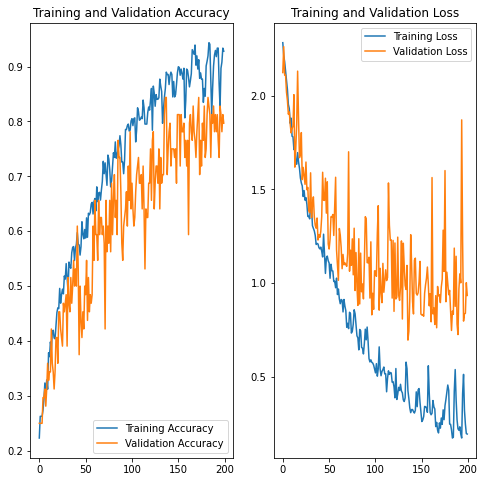

In [205]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Verticillium Wilt
1/1 [==============================] - 1s 638ms/step
predicted label: Verticillium Wilt


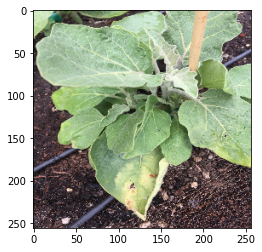

In [206]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [207]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


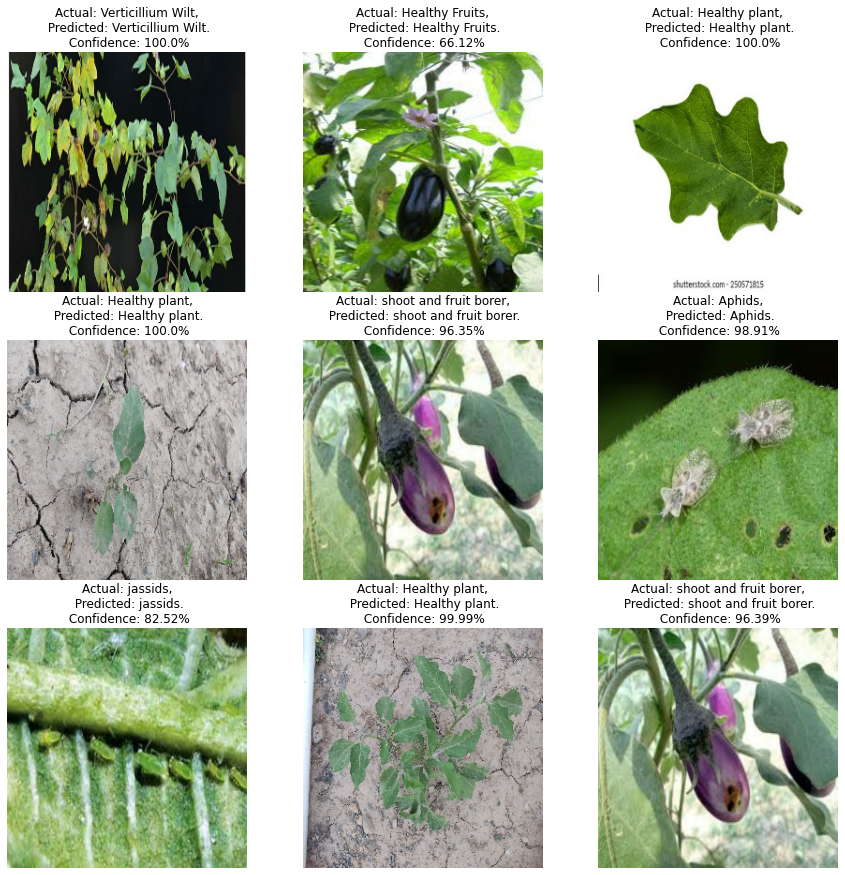

In [208]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [209]:
#Saving the Model
model.save("82accur.h5")